In [59]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

import skimage.io as io
import pickle

import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
#for colab
# from tensorflow.keras.optimizers import Adam

from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K

from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

## Loading data
a function that loads the images locations and labels.<br>
input: the data path.<br>
output:<br>
&emsp;&emsp;dataHiero -> a dataframe with index= location of images and label= their labels <br>
&emsp;&emsp;img_groups -> a dictionary in the shape of { "label" : [array of locations of images labeled with this label] }

In [ ]:
path="../GlyphDataset/Dataset/Manual/Preprocessed/"

def loadData(folderPictures=path):
    
    folders=next(os.walk(folderPictures))[1]
    img_groups = {}
    img_list={}

    for folder in folders:
        for img_file in os.listdir(folderPictures+folder):
            name, 
            label = img_file.strip('.png').split("_")
            
            
            # One image per class

            #if label not in img_groups.keys():
            #    img_groups[label] = [folder + "_" + name]


            # Multiple images per class

            if label in img_groups.keys():
                img_groups[label].append(folder+"_"+name)
            else:
                img_groups[label] = [folder+"_"+name]

            img_list[folder+"_"+name]=[label]


    # Remove class with only one hieroglyph


    for k,v in list(img_groups.items()):
        if len(v)==1: del img_groups[k]

    # Extract only N hieroglyph classes randomly

    nclass = len(img_groups.keys())

    list_of_class = random.sample(list(img_groups.keys()), nclass)
#     print(list_of_class)

    short_dico = {x: img_groups[x] for x in list_of_class if x in img_groups}

    dataHiero=pd.DataFrame.from_dict(img_list,orient='index')
    dataHiero.columns = ["label"]
    dataHiero = dataHiero[dataHiero.label != 'UNKNOWN']

    dataHiero = dataHiero.loc[dataHiero['label'].isin(short_dico)]


    dataHiero.reset_index(level=0, inplace=True)

    return dataHiero,img_groups

a function that takes the image groups and load those images<br>
input: img_proups dictionary<br>
output:<br>
&emsp;&emsp;X -> np array of the images<br>
&emsp;&emsp;y -> np array of labels<br>
&emsp;&emsp;glyph_sizes -> a dictionary in the form of {'label' : (starting index, ending index in X and y)}


In [ ]:
def read_images(img_groups,path):
    X=[]
    y=[]
    glyph_sizes={}
    low=0
    for glyph in img_groups:
        category_images=[]
        high=low
        for img_path in img_groups[glyph] :
            folder,name = img_path.split('_')
            image = io.imread(path+folder+'/'+name+'_'+glyph+'.png')
            X.append(image)
            y.append(glyph)
            high+=1
#         X.append(np.array(category_images))
        glyph_sizes[glyph]=(low,high-1)
        low=high
        
    return np.array(X),np.array(y).reshape((-1,1)),glyph_sizes
            
    

In [ ]:
dataHiero,img_groups=loadData(folderPictures=path)
dataHiero.head()
# img_groups

StopIteration: ignored

In [ ]:
X,y,sizes=read_images(img_groups,path)

In [ ]:
type(X)
print(y.shape)
print(X.shape)
sizes['D21'][1]

(2921, 1)
(2921, 75, 50)


5

saving the images into a pickle

In [ ]:
#train val split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

In [ ]:
def get_sizes(X,Y):
    sizes={}
    for i ,(x,y) in enumerate(zip(X,Y)):
#         print(i,x,y)
        if y[0] in sizes:
            sizes[y[0]].append(i)
        else:
            sizes[y[0]]=[i]
    return sizes
    

In [ ]:
sizes=get_sizes(X_train,y_train)
X=X_train
y=y_train

In [ ]:
#saving data as pickle
with open("train.pickle", "wb") as f:
    pickle.dump((X,y,sizes),f)

In [ ]:
sizes_val=get_sizes(X_test,y_test)
Xval=X_test
yval=y_test

In [ ]:
#saving data as pickle
with open("test.pickle", "wb") as f:
    pickle.dump((Xval,yval,sizes_val),f)

In [ ]:
# #saving data as pickle
# with open("test.pickle", "wb") as f:
#     pickle.dump((Xval,yval,sizes_val),f)

## reading the training tensors

In [2]:
#colab
# data_path= '/content/drive/MyDrive/hiero_cv/'
#local
data_path='./'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
with open(data_path+"train.pickle", "rb") as f:
    (X,y,sizes) = pickle.load(f)

In [5]:
with open(data_path+"test.pickle", "rb") as f:
    (Xval,yval,sizes_val) = pickle.load(f)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

### For later : weight initialization approach.

In [8]:

# def initialize_weights(shape, name=None):
#     """
#         The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#         suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
#     """
#     return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

# def initialize_bias(shape, name=None):
#     """
#         The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#         suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
#     """
#     return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

### model 2 : lower accuracy.

In [ ]:
# def get_siamese_model_2(input_shape):
#     """
#         Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#     """
    
#     # Define the tensors for the two input images
#     left_input = Input(input_shape)
#     right_input = Input(input_shape)
    
#     # Convolutional Neural Network
#     model = Sequential()
#     model.add(Conv2D(64, (3,3),strides=(2, 2), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling2D((2, 2), strides=2))
#     model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling2D((2, 2), strides=2))
#     model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
# #     model.add(MaxPooling2D())
# #     model.add(Conv2D(256, (4,4), activation='relu',  kernel_regularizer=l2(2e-4)))
#     model.add(Flatten())
#     model.add(Dense(4096, activation='sigmoid',
#                    kernel_regularizer=l2(1e-3)))
    
#     # Generate the encodings (feature vectors) for the two images
#     encoded_l = model(left_input)
#     encoded_r = model(right_input)
    
#     # Add a customized layer to compute the absolute difference between the encodings
#     L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#     L1_distance = L1_layer([encoded_l, encoded_r])
    
#     # Add a dense layer with a sigmoid unit to generate the similarity score
#     prediction = Dense(1,activation='sigmoid')(L1_distance)
    
#     # Connect the inputs with the outputs
#     siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
#     # return the model
#     return siamese_net

In [ ]:
# model_2 = get_siamese_model_2((75, 50, 1))
# model_2.summary()

In [ ]:
# optimizer = Adam(lr = 0.001)
# model_2.compile(loss="binary_crossentropy",optimizer=optimizer)

### Later : try transfer learning.

In [ ]:
# def transfer_model(input_shape):
#     """
#         Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#     """
    
#     # Define the tensors for the two input images
#     left_input = Input(input_shape)
#     right_input = Input(input_shape)
    
#     #Import inception model for transfer learning without output layers
#     base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_shape)
    
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     # let's add a fully-connected layer
#     x = Dense(1024, activation='relu')(x)
#     # and a logistic layer -- let's say we have 200 classes
#     model= Dense(200, activation='softmax')(x)
    
#     # this is the model we will train
# #     model = Model(inputs=base_model.input, outputs=predictions)
        
    
#     # Generate the encodings (feature vectors) for the two images
#     encoded_l = model(left_input)
#     encoded_r = model(right_input)
    
#     # Add a customized layer to compute the absolute difference between the encodings
#     L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#     L1_distance = L1_layer([encoded_l, encoded_r])
    
#     # Add a dense layer with a sigmoid unit to generate the similarity score
#     prediction = Dense(1,activation='sigmoid')(L1_distance)
    
#     # Connect the inputs with the outputs
#     model = Model(inputs=[left_input,right_input],outputs=prediction)
    
#     for layer in model.layers[:249]:
#        layer.trainable = False
#     for layer in model.layers[249:]:
#        layer.trainable = True
    
#     # return the model
#     return model

In [ ]:
# inception_model = transfer_model((75, 50, 1))
# inception_model.summary()

In [ ]:
# inception_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [12]:
from keras import backend as K

In [19]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu',  kernel_regularizer=l2(2e-4)))
    model.add(Flatten())

    model.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    
    L1_distance = L1_layer([encoded_l, encoded_r])
    L1_distance = Dense(512,activation='relu',kernel_regularizer=l2(1e-3))(L1_distance)
    L1_distance = Dense(256,activation='relu',kernel_regularizer=l2(1e-3))(L1_distance)
    # Add a dense layer with a sigmoid unit to generate the similarity score

    prediction = Dense(1,activation='sigmoid')(L1_distance)

    #cosine similarity (not learning anything)
    # def cosine_distance(vests):
    #   x, y = vests
    #   x = K.l2_normalize(x, axis=-1)
    #   y = K.l2_normalize(y, axis=-1)
    #   return -K.mean(x * y, axis=-1, keepdims=True)
    
    
    # prediction = Lambda(cosine_distance, output_shape=1)([encoded_l, encoded_r])
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [20]:
model = get_siamese_model((75, 50, 1))
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 75, 50, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 75, 50, 1)    0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 4096)         4891712     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_4[1][0]         

In [21]:
optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


a function that create pairs of images with y= 1 if they are similar and 0 if they are different. 

## a function to predict which glyph

In [22]:
def create_glyphlist(X,sizes):
    images=[]
    labels=[]
    _,w,h=X.shape
    for glyph in sizes:
        index=sizes[glyph][0]
        images.append(X[index].reshape( w , h, 1))
        labels.append(glyph)
    return np.asarray(images), np.asarray(labels) 

In [23]:
anchor_img, anchor_label=create_glyphlist(X,sizes)

In [24]:
def whichGlyph_pair(image,anchor_img,anchor_label):
    N,w,h,_=anchor_img.shape
#     pairs=[np.zeros((N, w, h,1)) for i in range(2)]
    
    test_image= np.asarray([image]*N).reshape(N, w, h,1)
    
    anchor_label, test_image, anchor_img = shuffle(anchor_label, test_image, anchor_img)
#     pairs = [test_image,anchor_img]
    
    return test_image, anchor_img, anchor_label
    

In [27]:
def whichGlyph(model,image,anchor_img,anchor_label):
    test_image,anchor_img,targets = whichGlyph_pair(image,anchor_img,anchor_label)
    probs = model.predict([test_image,anchor_img])
    return probs,anchor_img,targets
    

## creating pairs of images

In [28]:
def createPairs(X,y,sizes,batch_size):
    ##create a batch with half it's size are similar glyphs and the other half are different.
    n=0
    i=0
    
    label=[]
    _,w,h=X.shape
    # initialize 2 empty arrays for the input image batch
#     pairs=[np.zeros((batch_size, w, h,1)) for i in range(2)]
    input1=np.zeros((batch_size, w, h,1))
    input2=np.zeros((batch_size, w, h,1))
    
    while n < batch_size:
        random_key1=random.choice(list(sizes))
#         low=sizes[random_key1][0]
#         high=sizes[random_key1][1]
        index1, index3 = np.random.choice(sizes[random_key1], size=2)
        index2 = np.random.choice(sizes[random_key1])
        random_key2=random.choice(list(sizes))
        
        while random_key2 == random_key1:
            random_key2=random.choice(list(sizes))
            
#         low=sizes[random_key2][0]
#         high=sizes[random_key2][1]
        index4=np.random.choice(sizes[random_key2])
        n += 2
        # appending images 1 and 3 into input1 and input2 corresponding to y=1 
        #and images 2 and 4 corresponding to y=0
    
        input1[i,:,:,:] = X[index1].reshape( w , h, 1)
        input1[i+1,:,:,:] = X[index2].reshape(w, h, 1)
        input2[i,:,:,:] = X[index3].reshape(w, h, 1)
        input2[i+1,:,:,:] = X[index4].reshape(w, h, 1)
        i += 2
#         input1+=[X[index1],X[index2]]
#         input2+=[X[index3],X[index4]]
        label+=[1,0]
        
#         print(index1,index2,index3,index4)
#         print(y[index1],y[index2],y[index3],y[index4])
#         print(random_key1,random_key2)
    input1,input2,label = shuffle(input1,input2,label)
    pairs=[input1,input2]
    
    return pairs,label
pairs,label=createPairs(X,y,sizes,32)   

In [15]:
# pairs[1].shape
# label

a fn that creates a N-way one shot learning task where it create pairs with the wanted image and N-1 different ones and 1 similar one.

In [29]:
def make_oneshot_task(X,y,sizes,N):
    _,w,h=X.shape
    pairs=[np.zeros((N, w, h,1)) for i in range(2)]
    
    true_key=random.choice(list(sizes))
#     low=sizes[true_key][0]
#     high=sizes[true_key][1]
    
    index=np.random.choice(sizes[true_key])
    index2=np.random.choice(sizes[true_key])
    
    test_image= np.asarray([X[index]]*N).reshape(N, w, h,1)
#     print(X.shape)
    X_diff= np.delete(X,sizes[true_key],axis=0)
#     print(X_diff.shape)
    indices= np.random.choice(range(0, len(X_diff)), size = N-1)
    
    support_set=X_diff[indices,:,:]
    ##!!! adding the similar image to the start of the array is not working!!!!!!!!!!!!!!!!!!!!!
    
#     print(support_set.shape)
#     support_set = [ X[index2] ] + support_set
    support_set=np.insert(support_set,0,X[index2],axis=0)
#     print(support_set.shape)
    targets = np.zeros((N,))
    targets[0] = 1
    support_set=support_set.reshape(N,w,h,1)
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets
    


In [30]:
pp,tt=make_oneshot_task(Xval,yval,sizes_val,20) 
pp[0].shape

(20, 75, 50, 1)

In [31]:
# plt.imshow(pairs[0][0])
pairs[1].shape
# len(label)

(32, 75, 50, 1)

In [32]:
def test_oneshot(model,X,y,sizes, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(X,y,sizes,N)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [33]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 128 #32
n_iter = 20000 # No. of training iterations 20000
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [34]:
model_path = './weights/'
# model_2_path= '/content/drive/MyDrive/hiero_cv/weights/'
# model_cos_path= '/content/drive/MyDrive/hiero_cv/weights_cos/'
# model_regul='/content/drive/MyDrive/hiero_cv/regul_weights/'


In [35]:
X.shape

(2921, 75, 50)

In [34]:
# print("Starting training process!")
# print("-------------------------------------")
# t_start = time.time()
# for i in range(1, n_iter+1):
#     (inputs,targets) = createPairs(X,y,sizes,batch_size)
#     targets=np.asarray(targets)
#     loss = model.train_on_batch(inputs, targets)
#     if i % evaluate_every == 0:
#         print("\n ------------- \n")
#         print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
#         print("Train Loss: {0}".format(loss)) 
#         val_acc = test_oneshot(model,Xval,yval,sizes_val, N_way, n_val, verbose=True)
#         model.save_weights(os.path.join(model_regul, 'weights.{}.h5'.format(i)))
#         if val_acc >= best:
#             print("Current best: {0}, previous best: {1}".format(val_acc, best))
#             best = val_acc

In [24]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = createPairs(X,y,sizes,batch_size)
    targets=np.asarray(targets)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model,Xval,yval,sizes_val, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_2_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.4620641112327576 mins
Train Loss: 1.9128260612487793
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 26.4% 20 way one-shot learning accuracy 

Current best: 26.4, previous best: -1

 ------------- 

Time for 400 iterations: 1.1809937556584675 mins
Train Loss: 1.3017417192459106
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 52.8% 20 way one-shot learning accuracy 

Current best: 52.8, previous best: 26.4

 ------------- 

Time for 600 iterations: 1.8878071069717408 mins
Train Loss: 1.0451736450195312
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 66.0% 20 way one-shot learning accuracy 

Current best: 66.0, previous best: 52.8

 ------------- 

Time for 800 iterations: 2.5838430166244506 mins
Train Loss: 0.9491598010063171
Evaluating model on 250 random 20 way one

## loading model from weights

In [ ]:
# model_path=

In [36]:
model.load_weights('weights.20000.h5')

In [37]:
def calc_accuracy(N,Xval,yval,anchor_img,anchor_label,model):
    count_first=0
    count_first3=0
    for i in range(N):
        ind=random.choice(range(yval.shape[0]))
        predicted,anchor_imgs,targets=whichGlyph(model,Xval[ind],anchor_img,anchor_label)
        sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
        if targets[sort_index[-1]] == yval[ind][0]:
            count_first+=1
        if yval[ind][0] in targets[sort_index[127:]]:
            count_first3+=1
    accuracy_first=count_first/N
    accuracy_first3=count_first3/N
    
    return accuracy_first, accuracy_first3

In [38]:
t_start = time.time()
acc1,acc3=calc_accuracy(1000,Xval,yval,anchor_img,anchor_label,model)
print(f'testing:\nfound first accuracy = {acc1} , first 3 accuracy = {acc3}')
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))


testing:
found first accuracy = 0.837 , first 3 accuracy = 0.968
accuracy fn took 8.63333804210027 mins


In [32]:
t_start = time.time()
acc1,acc3=calc_accuracy(250,X,y,anchor_img,anchor_label,model)
print(f'training:\nfound first accuracy = {acc1} , first 3 accuracy = {acc3} ')
print("accuracy fn took {0} mins".format((time.time()-t_start)/60.0))

training:
found first accuracy = 0.972 , first 3 accuracy = 1.0 
accuracy fn took 0.447838568687439 mins


In [ ]:
# t_start = time.time()
# print(calc_accuracy(1,Xval,yval,anchor_img,anchor_label,model))
# print("accuracy fn took {0} sec".format((time.time()-t_start)))

### Testing new images

In [159]:
def preprocess(img):
    if len(img.shape) == 3 and img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img = cv2.resize(img,(50,75))
    return img

(75, 50)


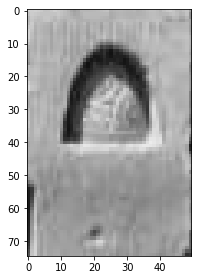

In [187]:
test_img1=io.imread('3.jpg')
test_img1=preprocess(test_img1)
print(test_img1.shape)
io.imshow(test_img1)


In [195]:
print(targets[64])
targets

X1


array(['U33', 'Q1', 'Y3', 'D39', 'N17', 'G29', 'G26', 'M23', 'Z1', 'M40',
       'D21', 'W18', 'T30', 'F34', 'G7', 'M12', 'W24', 'G39', 'M20',
       'N25', 'V7', 'D2', 'Y2', 'E34', 'E23', 'G40', 'N5', 'N18', 'G37',
       'W25', 'F18', 'D60', 'T20', 'G1', 'V28', 'N35', 'U1', 'N41',
       'M195', 'D56', 'D10', 'Q3', 'G36', 'D28', 'T21', 'W11', 'G25',
       'F31', 'E9', 'Q7', 'O34', 'M17', 'I10', 'Y5', 'V24', 'N30', 'X8',
       'S24', 'M41', 'N14', 'UNKNOWN', 'G35', 'S28', 'P6', 'X1', 'V30',
       'N29', 'Z7', 'R8', 'D156', 'V4', 'F16', 'D58', 'N31', 'G14', 'G17',
       'F13', 'F4', 'P98', 'D46', 'V31', 'G4', 'F9', 'D35', 'M1', 'O50',
       'O4', 'F35', 'P8', 'O31', 'S34', 'D4', 'M16', 'R4', 'O28', 'M3',
       'N36', 'Z11', 'N1', 'D36', 'D1', 'W22', 'D52', 'O49', 'M29', 'D19',
       'V6', 'U15', 'F26', 'G5', 'M44', 'M42', 'G43', 'U7', 'N37', 'T22',
       'H6', 'L1', 'E1', 'S29', 'I9', 'Aa27', 'T28', 'G21', 'M8', 'U28',
       'O1', 'Aa26', 'Aa15', 'F40', 'W19', 'P1', 'M18', 'D5

In [197]:
predicted[100]

array([0.65185916], dtype=float32)

In [171]:
predicted,anchor_imgs,targets=whichGlyph(model,test_img1.reshape(75,50,1),anchor_img,anchor_label)

In [172]:
sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
sort_index 

array([ 57,  22,  39, 121, 116,  20,  97, 125,  30,  62,  90,  15, 110,
        98,  29, 130,  50, 104,  93,  92, 111,   5,  86,  37,  56,  76,
       106,  59,  31,  83, 115, 122,  73, 134,  34,  44,  88,  72,  27,
         1, 107,  65,  87,  32,  89,  95,  55,  67, 133,  77,  94, 129,
       114,  38,  81,  49, 101,  11,   0,  63, 131, 132, 117,  19,  54,
        91, 127,   4, 108,  70,  99,  69,  46,  28,  84,   6,   2,  17,
       126, 113,  78,  40,  51, 124,  74,  79, 103,   3, 128,   7,   9,
         8,  24, 118,  43,  47,  35,  96,  18,  82, 119, 120, 105,  13,
        36, 102,  68,  66,  48,  42,  21,  61,  33,  25,  10,  52,  71,
        64, 109,  23,  75,  53,  14,  60,  12,  45, 123, 112,  80,  26,
        85,  58,  41,  16, 100])

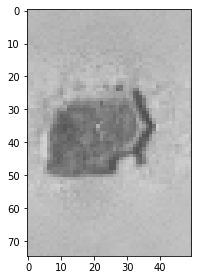

In [198]:
io.imshow(anchor_imgs[100].reshape(75,50))